In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from helpers.makemore_helpers import make_char2idx_map, build_dataset

words = open(r'data\names.txt','r').read().splitlines()
char2idx = make_char2idx_map(words)
idx2char = {v: k for k, v in char2idx.items()}

block_size = 3

In [2]:
train_count = int(len(words) * 0.8)
n_1 = int(len(words) * 0.9)

x_train, y_train = build_dataset(words[:train_count], block_size, char2idx)
x_val, y_val = build_dataset(words[train_count:n_1], block_size, char2idx)
x_test, y_test = build_dataset(words[n_1:], block_size, char2idx)

total_train = len(x_train)
total_val = len(x_val)
total_test = len(x_test)

print(f"Sizes:", total_train, total_val, total_test)
print("Shapes:", x_train.shape, y_train.shape)

Sizes: 182778 22633 22735
Shapes: torch.Size([182778, 3]) torch.Size([182778])


In [149]:
class Linear:
    def __init__(self,fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else [self.weight]



class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class BatchNorm:
    def __init__(self, fan_out, eps=1e-5, momentum=0.01):
        self.eps = eps
        self.momentum = momentum

        self.training = True

        # trainable parameters
        self.scale_by = torch.ones(fan_out)
        self.shift_by = torch.zeros(fan_out)

        # buffers
        self.running_mean = torch.zeros(fan_out)
        self.running_var = torch.ones(fan_out)

    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True, unbiased=True)

            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / (var + self.eps).sqrt()
        self.out = self.scale_by * x_hat + self.shift_by

        return self.out

    def parameters(self):
        return [self.scale_by, self.shift_by]





In [188]:
embedding_size = 10
vocab_size = len(char2idx)
hidden_size = 100

embedding_matrix = torch.randn(vocab_size, 10)

layers = [
    Linear(embedding_size * block_size, hidden_size), BatchNorm(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm(hidden_size), Tanh(),
    Linear(hidden_size, hidden_size), BatchNorm(hidden_size), Tanh(),
    Linear(hidden_size, vocab_size),
]


with torch.no_grad():
    # make softmax layer less confident
    layers[-1].weight *= 0.01
    # layers[-1].scale_by *= 0.01

    # apply gain to all other linear layers
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


params = [embedding_matrix] + [ p for layer in layers for p in layer.parameters() ]
print("Total parameters:", sum(p.numel() for p in params))

for p in params:
    p.requires_grad = True
    


Total parameters: 47497


In [189]:
steps = 50_000
batch_size = 64
losses = []
# lrs_used = []

update_to_data = []

for step in range(steps):

    # mini-batch
    batch_idx = torch.randint(0,total_train, (batch_size,))
    xs = x_train[batch_idx]
    ys = y_train[batch_idx]

    embedding = embedding_matrix[xs]
    x = embedding.view(embedding.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, ys)

    for layer in layers:
        layer.out.retain_grad()
    for p in params:
        p.grad = None

    loss.backward()

    # lr = learning_rates[step]
    lr = 0.1 if step < 10000 else 0.01
    for p in params:
        p.data += -lr * p.grad


    if step % 1000 == 0:
        print(f"Step {step:6d}: loss {loss.item():.4f}")

    
    # tracking
    losses.append(loss.log10().item())
    # lrs_used.append(lr)


    with torch.no_grad():
        updates = [
            (p.grad.std()/p.data.std()).log10().item()
            for p in params 
        ]

        update_to_data.append(updates)

    # break


Step      0: loss 3.2954
Step   1000: loss 2.2852
Step   2000: loss 1.9744
Step   3000: loss 2.1732
Step   4000: loss 2.1306
Step   5000: loss 2.1208
Step   6000: loss 2.1543
Step   7000: loss 2.0430
Step   8000: loss 2.0168
Step   9000: loss 2.3439
Step  10000: loss 1.9025
Step  11000: loss 1.9168
Step  12000: loss 2.2947
Step  13000: loss 1.9446
Step  14000: loss 2.2050
Step  15000: loss 2.1016
Step  16000: loss 2.0267
Step  17000: loss 2.2372
Step  18000: loss 2.1853
Step  19000: loss 2.1106
Step  20000: loss 2.0384
Step  21000: loss 1.8901
Step  22000: loss 1.9615
Step  23000: loss 1.9954
Step  24000: loss 2.1276
Step  25000: loss 2.2361
Step  26000: loss 1.8868
Step  27000: loss 2.1895
Step  28000: loss 1.9760
Step  29000: loss 2.0376
Step  30000: loss 1.8939
Step  31000: loss 2.0561
Step  32000: loss 2.1799
Step  33000: loss 2.0399
Step  34000: loss 1.9542
Step  35000: loss 2.2069
Step  36000: loss 1.9391
Step  37000: loss 2.2072
Step  38000: loss 2.1204
Step  39000: loss 2.1214


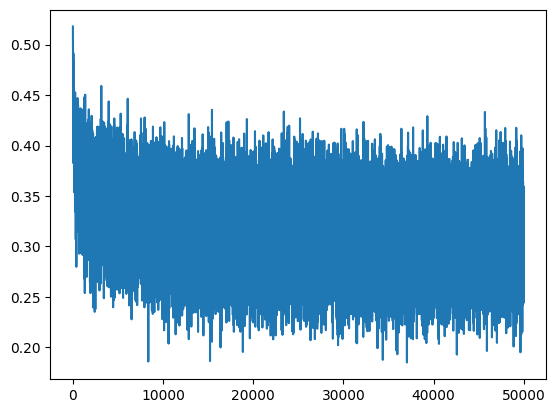

In [190]:
plt.plot(losses)

Layer 2 (Tanh) mean=0.0029 std=0.6419 saturated=5.0625%
Layer 5 (Tanh) mean=-0.0025 std=0.6543 saturated=5.9375%
Layer 8 (Tanh) mean=0.0065 std=0.6661 saturated=5.8594%
Layer 11 (Tanh) mean=-0.0031 std=0.6767 saturated=5.1719%
Layer 14 (Tanh) mean=0.0219 std=0.7071 saturated=5.8750%


Text(0.5, 1.0, 'activation distributions')

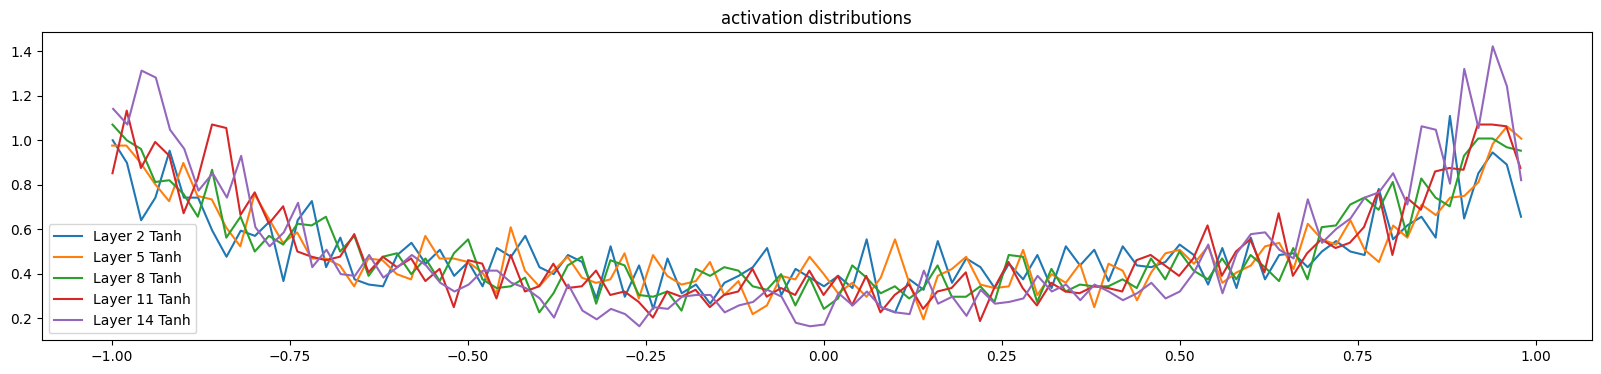

In [191]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if not isinstance(layer, Tanh):
        continue


    t = layer.out
    print(f"Layer {i} ({layer.__class__.__name__}) mean={t.mean():.4f} std={t.std():.4f} saturated={(t.abs() > 0.97).float().mean()*100:.4f}%")
    
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach() , hy.detach())

    legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.legend(legends)
plt.title("activation distributions")


Layer 2 (Tanh) mean=0.0000 std=0.0026 saturated=0.0000%
Layer 5 (Tanh) mean=-0.0000 std=0.0026 saturated=0.0000%
Layer 8 (Tanh) mean=-0.0000 std=0.0025 saturated=0.0000%
Layer 11 (Tanh) mean=-0.0000 std=0.0024 saturated=0.0000%
Layer 14 (Tanh) mean=-0.0000 std=0.0021 saturated=0.0000%


Text(0.5, 1.0, 'gradient distributions')

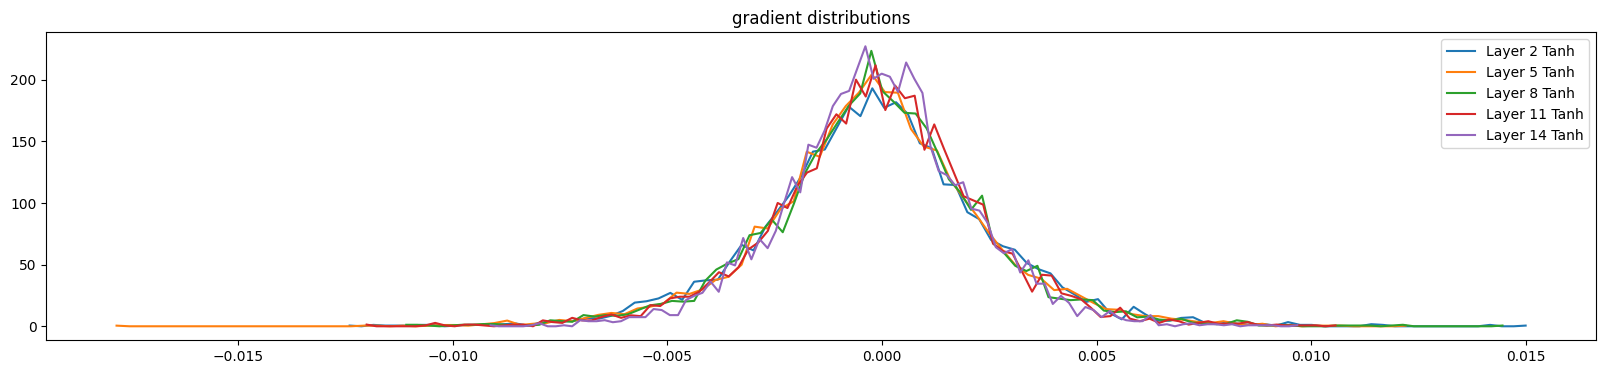

In [192]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if not isinstance(layer, Tanh):
        continue


    t = layer.out.grad
    print(f"Layer {i} ({layer.__class__.__name__}) mean={t.mean():.4f} std={t.std():.4f} saturated={(t.abs() > 0.97).float().mean()*100:.4f}%")
    
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach() , hy.detach())

    legends.append(f"Layer {i} {layer.__class__.__name__}")

plt.legend(legends)
plt.title("gradient distributions")

Weight 0 shape=(torch.Size([27, 10])), mean=-0.0000, std=0.0125, grad to data ratio=0.0130
Weight 1 shape=(torch.Size([30, 100])), mean=-0.0000, std=0.0089, grad to data ratio=0.0277
Weight 5 shape=(torch.Size([100, 100])), mean=-0.0001, std=0.0074, grad to data ratio=0.0414
Weight 9 shape=(torch.Size([100, 100])), mean=0.0001, std=0.0073, grad to data ratio=0.0409
Weight 13 shape=(torch.Size([100, 100])), mean=-0.0001, std=0.0073, grad to data ratio=0.0411
Weight 17 shape=(torch.Size([100, 100])), mean=-0.0001, std=0.0063, grad to data ratio=0.0358
Weight 21 shape=(torch.Size([100, 27])), mean=0.0000, std=0.0131, grad to data ratio=0.0876


Text(0.5, 1.0, 'weight gradient distributions')

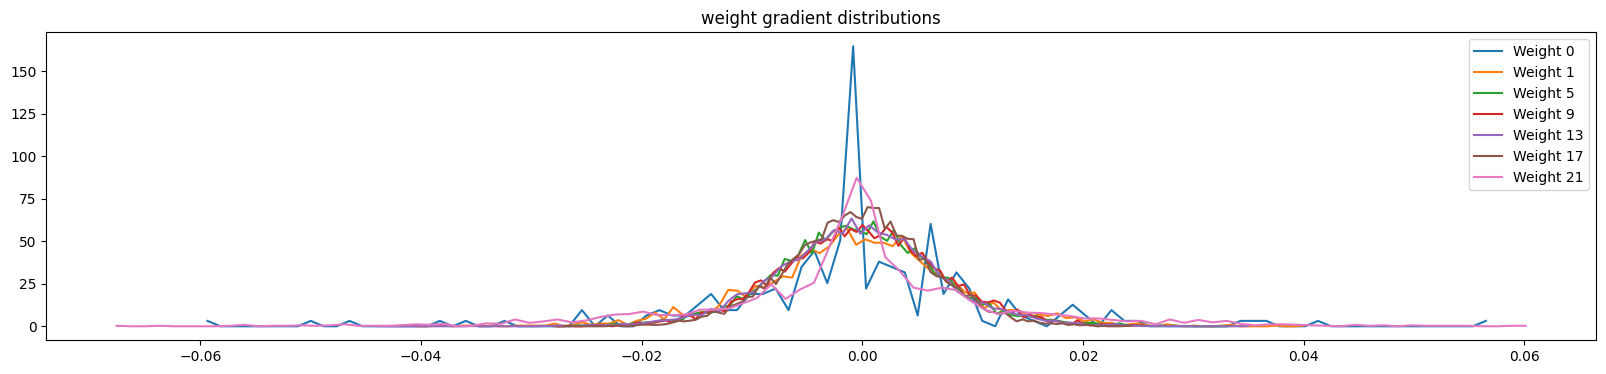

In [193]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(params):
    if p.ndim != 2:
        continue

    t = p.grad
    print(f"Weight {i} shape=({p.shape}), mean={t.mean():.4f}, std={t.std():.4f}, grad to data ratio={t.std()/p.std():.4f}")
    
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach() , hy.detach())

    legends.append(f"Weight {i}")

plt.legend(legends)
plt.title("weight gradient distributions")

Text(0.5, 1.0, 'data to gradient ratio')

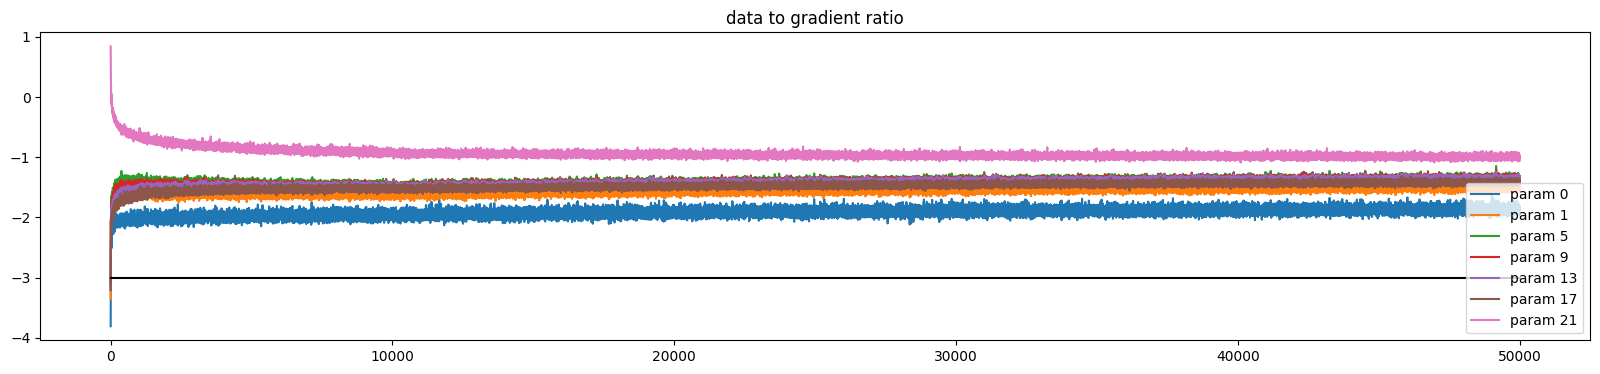

In [194]:
# This gradient:data ration should be around 10e-3. If it's way below the 10e-3 line, your learning rate is too low


plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(params):
    if p.ndim != 2:
        continue

    plt.plot([update_to_data[j][i] for j in range(len(update_to_data))])
    legends.append(f"param {i}")


plt.plot([0, len(update_to_data)], [-3,-3], 'k')
plt.legend(legends)
plt.title("data to gradient ratio")



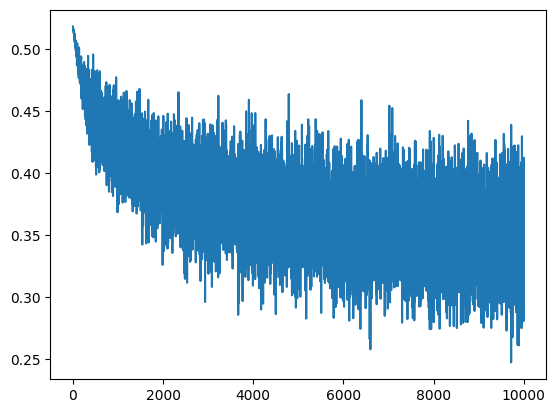

In [167]:
plt.plot(losses)

In [195]:

@torch.no_grad()
def eval_loss(set_name: str):
    xs, ys = {
        "train": (x_train, y_train),
        "val": (x_val, y_val),
        "test": (x_test, y_test),
    }[set_name]

    embedding = embedding_matrix[xs]

    x = embedding.view(embedding.shape[0], -1)
    for layer in layers:
        if isinstance(layer, BatchNorm):
            layer.training = False
        x = layer(x)

    loss = F.cross_entropy(x, ys)
    print(f"{set_name} loss: {loss.item():.4f}")
    

eval_loss("train")
eval_loss("val")

train loss: 2.0242
val loss: 2.3214


In [196]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        embedding = embedding_matrix[torch.tensor(context)]

        x = embedding.view(1, -1)
        for layer in layers:
            if isinstance(layer, BatchNorm):
                layer.training = False
            x = layer(x)

        p = F.softmax(x, dim=1)
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()

        context = context[1:] + [idx]
        if idx == 0:
            break

        out.append(idx)

    print("".join(idx2char[idx] for idx in out))

kaylartlenah
shope
khanell
rayshalisa
car
zepayanayel
daylyn
clarel
arlexon
nimreya
yaja
kharimarry
skahairi
lilan
aariddory
jensamaukingpe
jackarlag
harziel
eritjesseytuf
avion
